# Исследовательский анализ данных

# Определение возраста покупателей

## Описание проекта
    Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 
    Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
    
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
    
    Построим модель, которая по фотографии определит приблизительный возраст человека.
    Обучим модель на наборе фотографий людей с указанием возраста.

## Исследовательский анализ данныx

In [2]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [3]:
#загрузим датасет с возрастом и исследуем
df = pd.read_csv('/datasets/faces/labels.csv')
display(df.shape)
display(df.head())

(7591, 2)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
display(df.info())
display(df.describe())
print(df['real_age'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64


Text(0, 0.5, 'Количество')

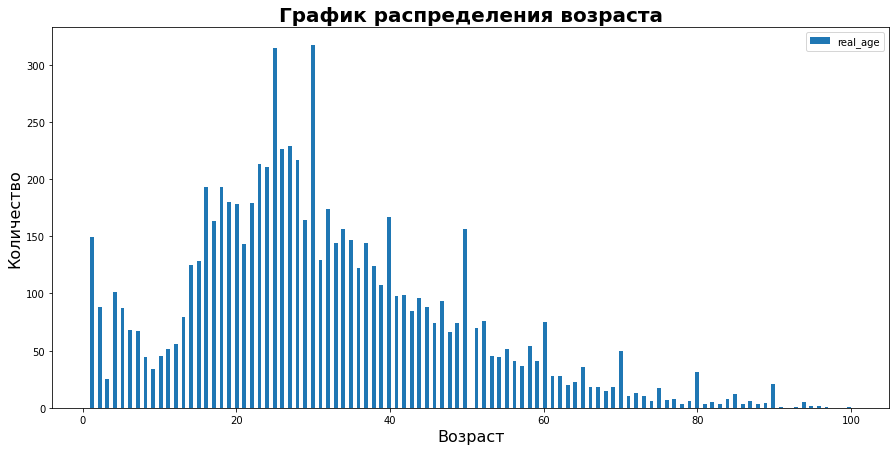

In [5]:
#построим график распределения возраста
df.plot(y='real_age', kind='hist', bins=200, figsize=(15, 7))
plt.title('График распределения возраста', fontsize=20, fontweight='bold')
plt.xlabel('Возраст', fontsize=16)
plt.ylabel('Количество', fontsize=16)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs
Found 5694 validated image filenames.


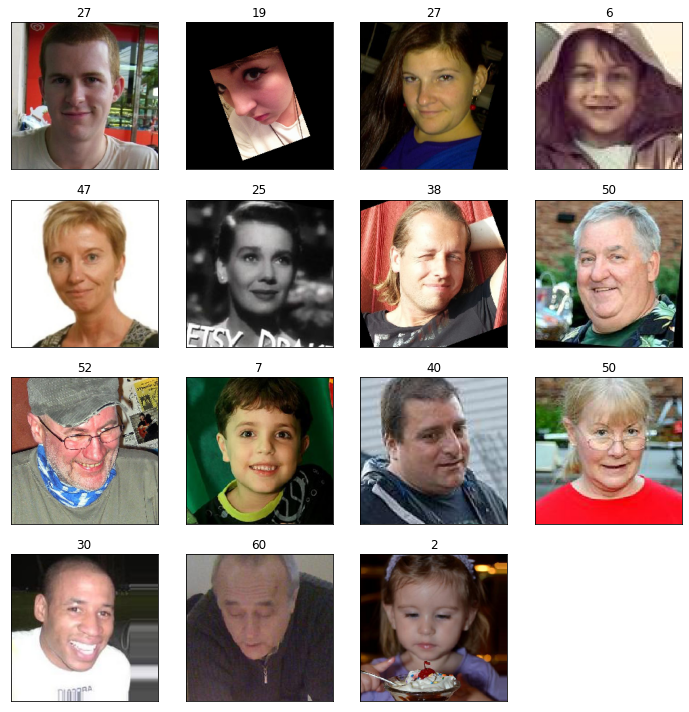

In [7]:
%time

#выведем изображения и фактический возраст для визуальной оценки
path='/datasets/faces/'
datagen = ImageDataGenerator(rescale=1 / 255, validation_split=0.25)
dataframe = pd.read_csv(path + 'labels.csv')
    
train_datagen_flow = datagen.flow_from_dataframe(dataframe=dataframe,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                class_mode='raw',
                                                subset='training',
                                                seed=12345)

features, target = next(train_datagen_flow)
# выводим 15 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(str(target[i]))
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод
- размер выборки - 7591 записей, уникальных значений 97 в диапазоне возраста от 1 года до 100 лет
- согласно графику распределения есть выбросы до 5 лет, в диапазоне ~25-30лет, далее каждые 10лет (кроме 100лет)
- требуется дополнительная проверка связи фото и реального возраста по данным выбросам (ПРИВЕТ! Подскажи пожалуйста как выбрать ТОЛЬКО фото в диапазонах интересующих нас возрастов?)
- среди примеров фото: присутствуют представители разных расс, фото разного качества, часть лиц могут быть закрыты одеждой. Все это может замедлять/нарушать процесс обучения модели и влиять на точность результата определения возраста

In [ ]:
#получим список фото выбранного нами возраста
df_age = df.query('real_age == 1')
display(df_age.head())

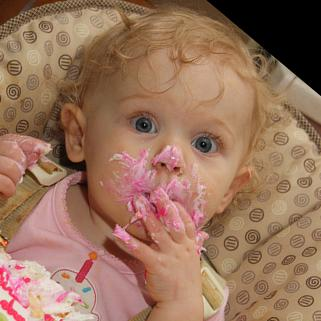

In [91]:
#выведем фото из списка, - проверим визуально соответствие фото и возраста
from IPython.display import display, Image
display(Image(filename='/datasets/faces/final_files/000013.jpg'))

## Обучение модели в GPU-тренажёре и сохранение результата вывода модели на экран

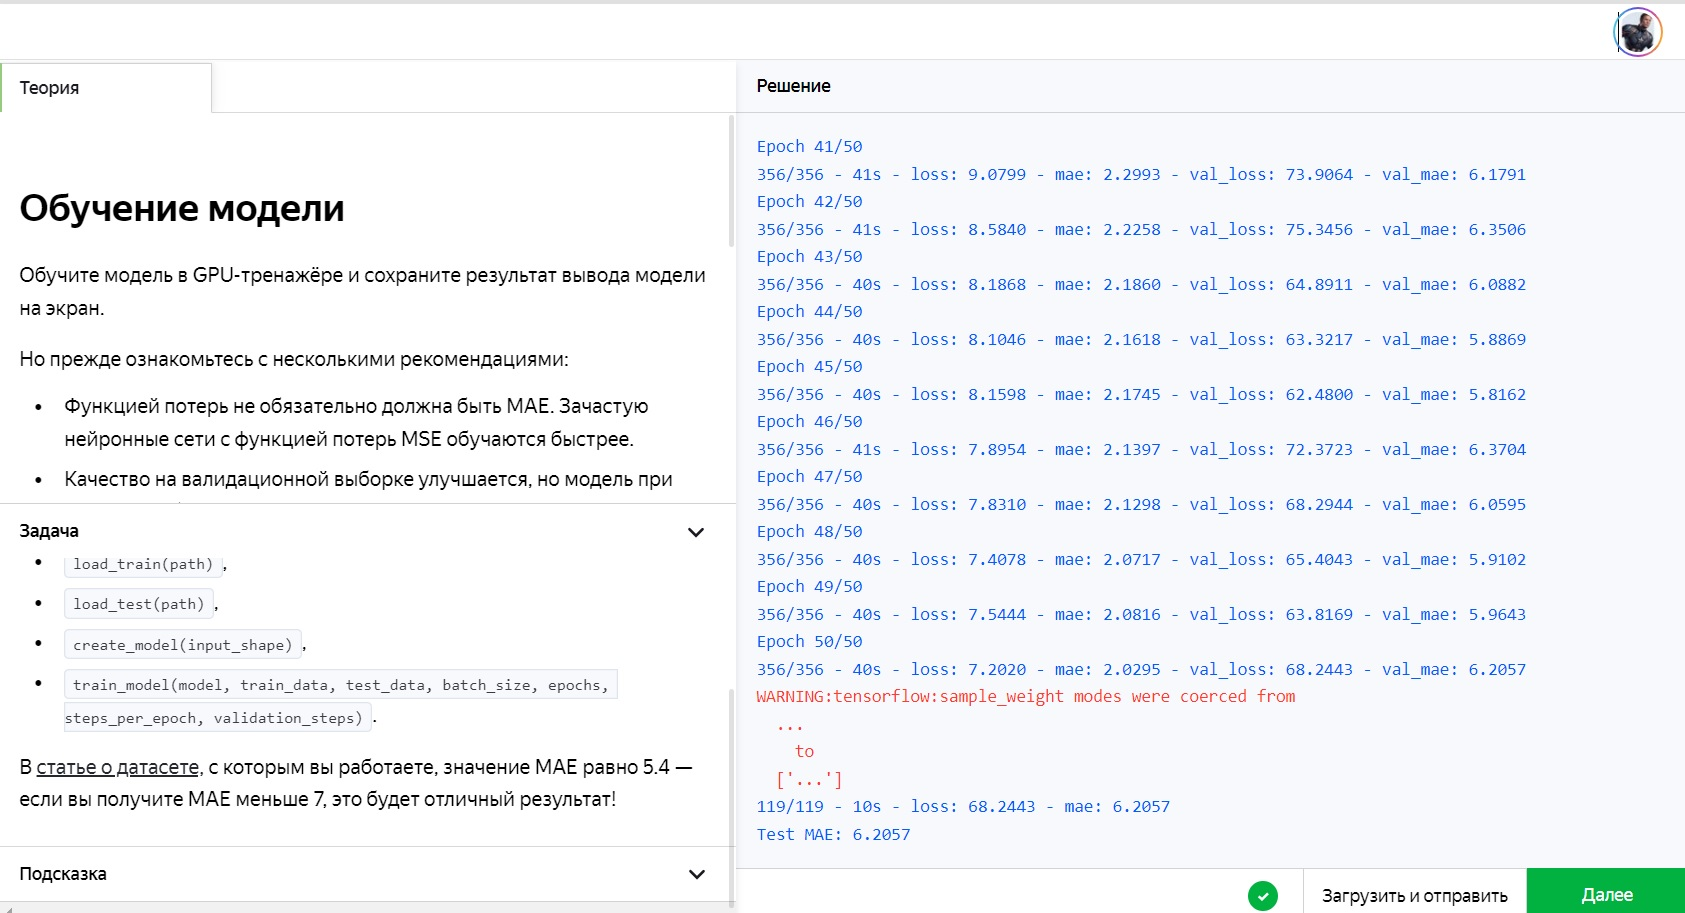

### Вывод
- удалось добиться качества MAE 6,2. Т.е точность определения возраста данной модели +/- 6,2 года
- если целью создания модели ставится..:
       - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
       - Контролировать добросовестность кассиров при продаже алкоголя.
..То например данная модель может "не заметить" если алкоголь будет продан ребенку возрастом меньше 18лет. (18 - 6,2 = 11,8 лет).
Потребности возрастных групп могут находиться в бо'льших диапазонах чем ошибка модели.

## Объединим исследовательский анализ данных, код и вывод модели. Проанализируем результат обучения модели.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D

#применим аугменатцию только к тренировочной части данных
def load_train(path):
    datagen = ImageDataGenerator(rescale=1/255,
                                 validation_split=0.25,
                                 horizontal_flip=True)
    dataframe = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=dataframe,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                class_mode='raw',
                                                subset='training',
                                                seed=12345)
    return train_datagen_flow 


def load_test(path):
    datagen = ImageDataGenerator(rescale=1/255,
                                 validation_split=0.25)
    dataframe = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=dataframe,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                class_mode='raw',
                                                subset='validation',
                                                seed=12345)
    return test_datagen_flow 



def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    optimizer = Adam(lr=0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=50,
               steps_per_epoch=None, validation_steps=None):       
    model.fit(train_data, 
              validation_data=test_data,    
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

### Вывод
- MAE данной модели преодолела порог 8 и составила 6,2.

## Общий вывод
- выполнена цель работы - создать модель и получить необходимое значение MAE ниже 8.

- модель с данной точностью не рекомендована для проверки добросовестности кассиров в вопросе продажи алкоголя, тк "не заметит" если алкоголь будет продан ребенку 11-12 лет. Субъективно считаю что для данной цели подойдет модель с MAE не выше 1-2 (года).

- повысить точность модели возможно изучив выбросы, исключив фото несоответствующие возрасту (если такие есть), а также повысив количество эпох при обучении выше 50 а также используя для обучения и для теста фото более высокого качества/разрешения.